In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.tabular.all import *
from wwf.tab.export import *

In [3]:
from bnb import *

In [4]:
SEASON = '21'
set_seed(int(SEASON))

## Data preparation

In [5]:
path = Path()
path_data = Path('data')

In [6]:
df = pd.read_csv(path_data/'data.csv', dtype={'HC':'float', 'AC':'float'}, parse_dates=['Date'])

In [7]:
div = ['E0', 'D1', 'SP1', 'I1', 'F1']
df = df[(df.Div.isin(div)) & (df.Season >= 16) & (df.Season <= 21)]

# Drop NA corner
df = df.dropna().reset_index(drop=True)

In [8]:
add_datepart(df, 'Date');

In [9]:
procs = [Categorify, FillMissing, Normalize]

In [10]:
valid_idx = list(df.query('Season == 21').index)

In [11]:
splitter = IndexSplitter(valid_idx)
splits = splitter(range_of(df))

In [12]:
splits

((#9010) [0,1,2,3,4,5,6,7,8,9...],
 (#712) [1528,1529,1530,1531,1532,1533,1534,1535,1536,1537...])

In [13]:
y_names = ['HC', 'AC']
cat_names = ['Div', 'HomeTeam', 'AwayTeam']
cont_names = list(df.columns[df.columns.str.contains('Avg')])

In [14]:
y_block = RegressionBlock(n_out=2)

In [15]:
df.sample(10)

,Div,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HC,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
905,D1,Stuttgart,Wolfsburg,3.0,0.0,11.0,8.0,4.0,2.0,4.0,...,11,5,131,False,False,False,False,False,False,1.557533e+09
1658,E0,Stoke,Man City,1.0,4.0,8.0,12.0,3.0,6.0,7.0,...,20,5,233,False,False,False,False,False,False,1.471651e+09
6821,I1,Juventus,Spal,2.0,0.0,17.0,4.0,10.0,1.0,13.0,...,28,5,271,False,False,False,False,False,False,1.569629e+09
653,D1,Mainz,Wolfsburg,0.0,0.0,11.0,12.0,2.0,4.0,5.0,...,26,2,269,False,False,False,False,False,False,1.537920e+09
5508,F1,Marseille,St Etienne,3.0,1.0,19.0,11.0,5.0,7.0,5.0,...,28,5,240,False,False,False,False,False,False,1.630109e+09
891,D1,Hertha,Stuttgart,3.0,1.0,11.0,14.0,6.0,1.0,2.0,...,4,5,124,False,False,False,False,False,False,1.556928e+09
9545,SP1,Elche,Alaves,0.0,2.0,11.0,9.0,4.0,2.0,7.0,...,11,1,131,False,False,False,False,False,False,1.620691e+09
6103,I1,Cagliari,Benevento,2.0,1.0,13.0,9.0,5.0,3.0,5.0,...,25,2,298,False,False,False,False,False,False,1.508890e+09
9067,SP1,Leganes,Alaves,1.0,1.0,19.0,8.0,6.0,4.0,6.0,...,29,5,60,True,False,False,False,False,False,1.582934e+09
5363,F1,Marseille,Lyon,1.0,1.0,12.0,11.0,2.0,1.0,7.0,...,28,6,59,True,False,False,False,False,False,1.614470e+09


In [16]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block, splits=splits)

In [17]:
to.cat_names, to.cont_names

((#3) ['Div','HomeTeam','AwayTeam'],
 (#24) ['FTHGLast5Avg','HSLast5Avg','HSTLast5Avg','HCLast5Avg','FTAGLast5Avg','ASLast5Avg','ASTLast5Avg','ACLast5Avg','HomeFTGForLast5Avg','HomeSForLast5Avg'...])

In [18]:
display_df(to.xs.iloc[-2:])

,Div,HomeTeam,AwayTeam,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg
9720,5,100,40,-1.026961,-0.929232,-1.077094,-0.542910,-0.684256,-1.677110,-1.346609,-0.370452,-1.738316,-0.752407,-1.111434,-0.496333,-0.599344,-0.753483,-0.614364,0.403814,-0.326165,0.350815,-0.803735,0.007629,1.062019,1.412046,0.761782,-0.761810
9721,5,107,7,0.608916,0.804092,0.452740,-0.415778,-0.996705,0.310861,-0.327414,1.419811,0.927797,1.661078,0.949685,0.060961,-0.891483,0.809747,0.200082,1.362466,-0.982891,0.009162,-0.357693,0.145023,-0.607912,-0.463102,-0.897722,-0.623223


### To other packages (e.g. Scikit-learn, LightGBM, XGBoost)

In [19]:
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, XGBRFRegressor

In [20]:
X_train, y_train = to.train.xs, to.train.ys.values
X_test, y_test = to.valid.xs, to.valid.ys.values

In [21]:
X_train.shape, y_train.shape

((5377, 27), (5377, 2))

In [22]:
X_test.shape, y_test.shape

((712, 27), (712, 2))

## LightGBM

In [23]:
fit_params = {'feature_name':list(X_test.columns), 'categorical_feature':cat_names}

In [24]:
m_lgbm = MultiOutputRegressor(LGBMRegressor(objective='poisson', n_estimators=100, n_jobs=-1, reg_lambda=1.0))
m_lgbm.fit(X_train, y_train, **fit_params)

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


MultiOutputRegressor(estimator=LGBMRegressor(objective='poisson',
                                             reg_lambda=1.0))

In [25]:
import lightgbm as lgbm

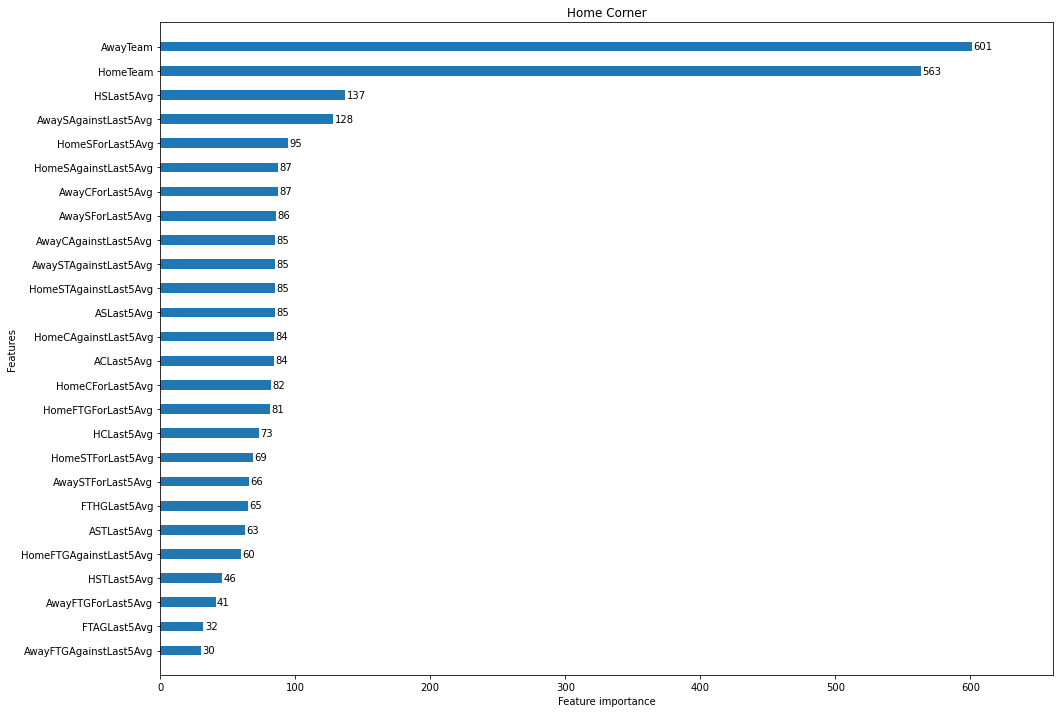

In [26]:
lgbm.plot_importance(m_lgbm.estimators_[0], figsize=(16, 12), title='Home Corner', max_num_features=40, height=0.4, grid=False);

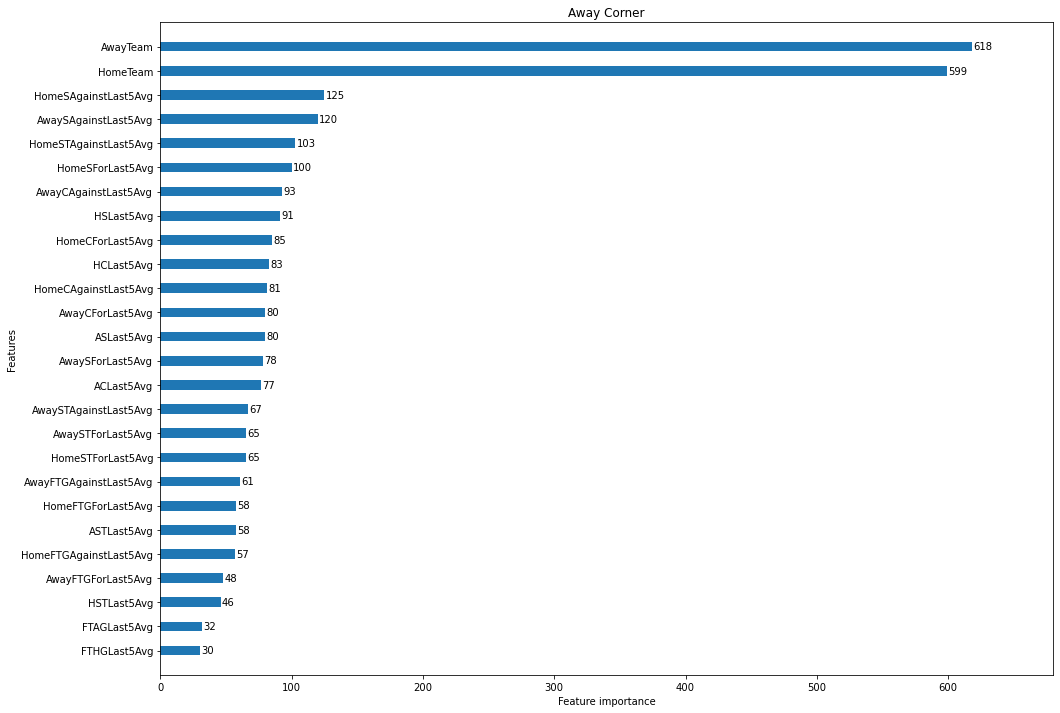

In [27]:
lgbm.plot_importance(m_lgbm.estimators_[1], figsize=(16, 12), title='Away Corner', max_num_features=40, height=0.4, grid=False);

## XGBoost

In [31]:
m_xgb = MultiOutputRegressor(XGBRegressor(objective='count:poisson', n_estimators=100, n_jobs=-1, tree_method='exact'))
m_xgb.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            objective='count:poisson',
                                            rand

In [32]:
import xgboost as xgb

In [33]:
for i in range(0, 2):
    m_xgb.estimators_[i].get_booster().feature_names = list(X_test.columns)

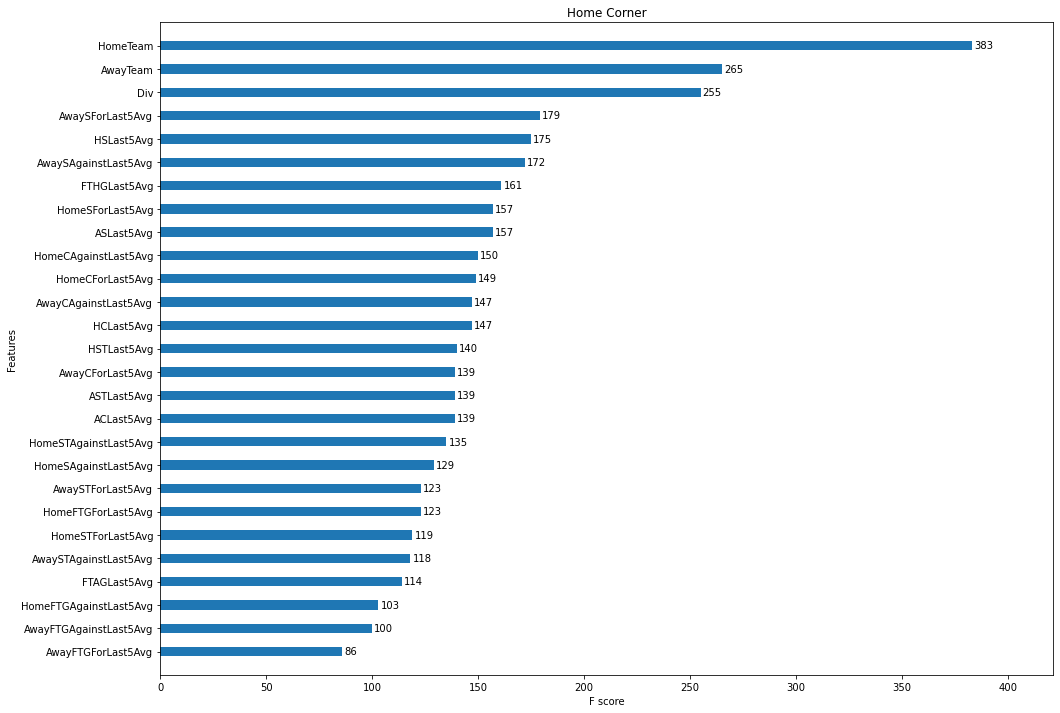

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
xgb.plot_importance(m_xgb.estimators_[0], title='Home Corner', max_num_features=40, height=0.4, grid=False, ax=ax);

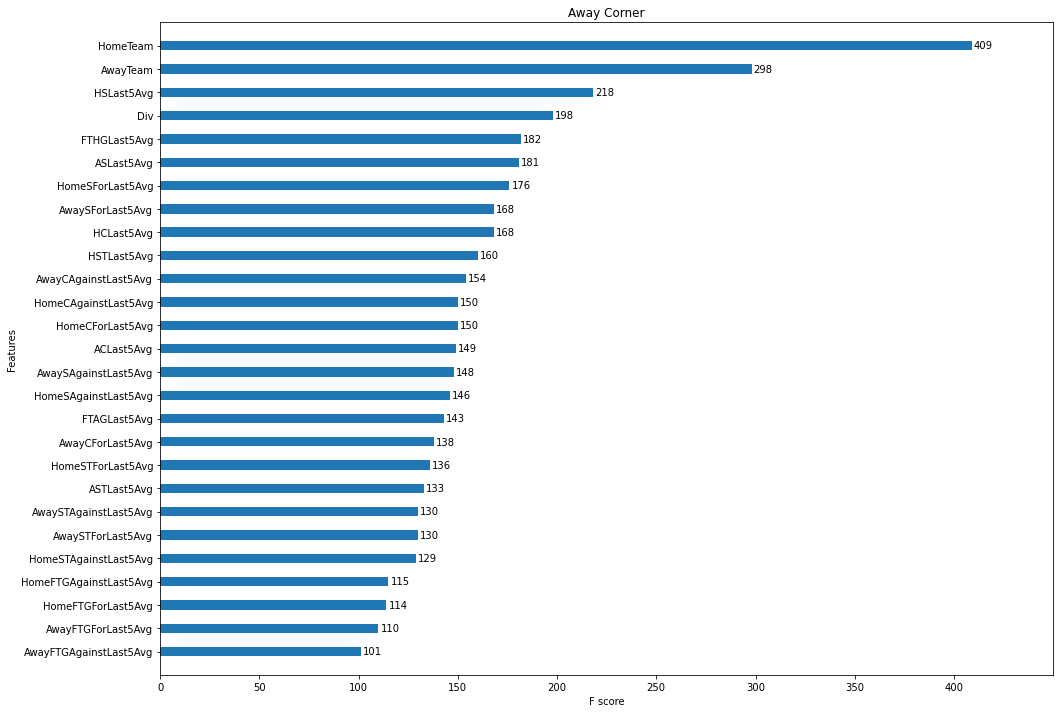

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
xgb.plot_importance(m_xgb.estimators_[1], title='Away Corner', max_num_features=40, height=0.4, grid=False, ax=ax);

## Poisson

In [42]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg,HC,AC
0,E0,Man United,Southampton,2.0,16.6,6.4,5.8,0.8,8.2,2.6,4.4,0.8,13.2,4.6,5.8,0.4,11.200000,3.8,4.2,0.6,12.4,2.8,3.6,1.2,11.6,3.6,4.2,5.0,3.0
1,SP1,Ath Bilbao,Valencia,2.0,9.2,3.2,3.8,1.0,11.8,4.8,4.0,1.8,8.6,3.0,3.4,1.0,12.000000,4.2,6.6,1.4,9.8,4.4,4.6,1.0,11.6,3.4,5.6,6.0,6.0
2,D1,Bayern Munich,M'gladbach,2.4,16.0,6.4,7.0,1.4,10.4,3.2,3.6,1.8,18.6,6.2,10.2,2.0,14.000000,4.4,5.8,0.8,7.0,2.2,1.2,1.8,14.8,5.0,7.0,1.0,3.0
3,D1,Schalke 04,Hoffenheim,0.2,10.2,2.4,1.8,2.2,16.0,6.8,5.4,1.0,11.2,4.0,3.8,2.6,20.000000,7.0,6.6,1.6,16.6,5.0,7.0,0.6,11.0,3.0,4.2,6.0,1.0
4,D1,Fortuna Dusseldorf,Leverkusen,1.6,12.4,5.2,4.6,1.0,9.6,2.8,4.4,1.4,12.2,6.0,4.8,1.2,15.399999,4.0,4.6,1.2,15.6,4.8,4.4,2.0,14.0,5.2,5.4,7.0,5.0
5,I1,Juventus,Sassuolo,2.0,15.0,6.6,6.2,1.4,12.4,5.0,3.6,1.8,18.0,8.6,7.0,2.0,11.600000,5.4,3.0,0.8,8.2,3.4,3.0,1.4,13.0,6.6,9.2,10.0,4.0
6,F1,Nimes,Angers,1.4,12.6,4.4,5.6,1.2,10.0,3.0,3.6,0.4,10.0,2.6,4.4,1.4,9.600000,3.6,4.6,1.6,17.0,6.0,6.4,2.6,12.4,5.4,4.4,6.0,2.0
7,F1,Montpellier,Lyon,2.0,15.8,7.8,5.0,1.0,12.4,4.0,5.0,1.4,15.0,6.0,5.8,1.6,16.799999,6.4,6.0,1.8,13.6,6.4,5.2,0.4,7.8,1.8,3.8,4.0,11.0
8,E0,Watford,West Ham,0.6,12.8,3.8,5.0,1.4,13.4,5.0,6.0,0.4,12.2,3.4,5.8,1.8,12.400000,5.6,3.6,2.6,12.6,5.4,3.8,1.4,14.4,5.2,5.0,8.0,7.0
9,E0,West Brom,West Ham,1.0,11.8,3.8,6.2,1.6,13.8,3.8,4.0,1.0,9.2,2.6,5.4,1.0,14.600000,3.0,4.8,2.2,20.4,8.2,8.6,1.4,12.0,4.4,3.8,6.0,8.0


In [43]:
learn = tabular_learner(dls, layers=[240, 120])

In [44]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(6, 4)
    (1): Embedding(130, 24)
    (2): Embedding(130, 24)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=76, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=2, bias=True)
    )
  )
)

In [45]:
learn.loss_func = BaseLoss(partial(nn.PoissonNLLLoss, log_input=True, full=True), floatify=True)

SuggestedLRs(valley=0.0030199517495930195)

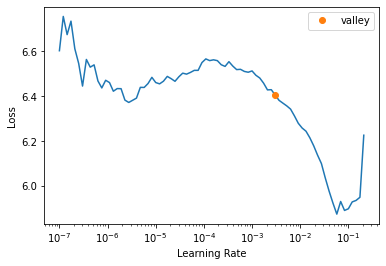

In [46]:
learn.lr_find()

In [47]:
learn.fit_one_cycle(5, 3e-2)

epoch,train_loss,valid_loss,time
0,3.395505,2.436060,00:00
1,2.634399,2.379112,00:00
2,2.419422,2.339252,00:00
3,2.357017,2.354592,00:00
4,2.300053,2.362964,00:00


In [48]:
df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')

,Div,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HC,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
2184,E0,Tottenham,Man City,1.0,0.0,13.0,18.0,3.0,4.0,3.0,...,15,6,227,False,False,False,False,False,False,1.628986e+09


In [49]:
_, _, params = learn.predict(df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')
                               .drop(columns=y_names).iloc[0])

In [50]:
pois_corner_home = torch.distributions.poisson.Poisson(params[0].exp())
pois_corner_away = torch.distributions.poisson.Poisson(params[1].exp())

In [51]:
print(pois_corner_home.mean, pois_corner_home.variance)
print(pois_corner_away.mean, pois_corner_away.variance)

tensor(4.6380) tensor(4.6380)
tensor(5.6992) tensor(5.6992)


In [52]:
corner_home = pois_corner_home.log_prob(torch.arange(0., 15.)).exp()
corner_away = pois_corner_away.log_prob(torch.arange(0., 15.)).exp()
corner = torch.ger(corner_home, corner_away)
mask = torch.zeros_like(corner)

In [53]:
mask = torch.zeros_like(corner)
line = 10.5
for i in range(0, mask.size()[0]):
    for j in range(0, mask.size()[1]):
        if i + j < line: mask[i, j] = 1. 

In [54]:
prob_lo = (corner * mask).sum()
prob_hi = 1 - prob_lo

In [55]:
prob_lo, prob_hi

(tensor(0.5409), tensor(0.4591))

## Negative Binomial

In [20]:
y_block = RegressionBlock(n_out=4)

In [21]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block, splits=splits)

In [22]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg,HC,AC
0,I1,Spal,Udinese,1.0,9.2,4.6,6.0,0.8,10.6,4.2,5.4,0.6,10.6,4.4,4.8,0.6,6.4,1.6,1.200000,1.2,10.800000,6.6,4.6,1.0,15.4,5.2,9.4,7.0,2.0
1,E0,Man United,Swansea,1.2,17.4,5.4,6.6,0.4,8.2,2.2,3.4,1.6,12.0,4.4,3.8,0.6,9.2,3.0,6.400000,0.2,10.400000,2.8,4.4,1.0,12.8,5.0,4.8,5.0,2.0
2,I1,Milan,Udinese,0.6,12.2,7.6,6.6,1.2,7.6,3.6,5.0,1.0,10.8,7.2,4.8,1.6,8.6,4.6,5.400000,1.4,9.400000,5.6,4.2,1.0,11.8,5.6,7.6,9.0,3.0
3,SP1,Osasuna,Las Palmas,0.6,14.2,6.0,7.4,1.8,9.0,4.8,3.0,0.8,11.0,4.4,6.4,2.0,8.8,5.0,2.600000,2.4,13.000000,5.4,3.6,1.8,16.6,5.8,5.6,1.0,12.0
4,I1,Inter,Lazio,2.4,23.0,7.6,10.0,2.6,13.0,4.2,6.0,1.8,19.0,6.0,10.4,2.2,15.8,5.4,8.399999,1.0,11.600000,5.0,3.2,1.6,14.2,5.0,4.0,10.0,8.0
5,F1,Montpellier,Toulouse,1.6,13.2,4.2,4.8,0.2,8.6,3.8,3.8,1.4,13.2,3.8,5.4,0.2,7.8,2.8,3.800000,2.4,10.400000,5.0,4.6,1.0,13.2,4.0,5.6,5.0,8.0
6,SP1,Barcelona,Granada,3.6,14.0,7.8,4.2,0.6,10.2,2.0,3.4,2.6,13.0,7.0,4.6,1.0,11.6,2.6,5.000000,1.4,11.600000,3.6,5.2,1.4,14.0,5.0,4.2,7.0,0.0
7,F1,Lille,Metz,1.4,13.6,3.8,4.6,0.6,8.4,3.4,2.6,1.6,15.6,5.0,4.4,1.4,8.4,3.8,3.200000,0.8,12.800000,5.2,5.0,2.8,15.0,5.6,5.4,11.0,2.0
8,SP1,Espanol,Vallecano,1.0,13.6,4.6,4.6,0.4,11.8,3.4,5.4,1.4,13.8,2.2,2.2,1.8,12.0,5.2,4.600000,2.4,13.000000,5.8,5.6,1.2,12.8,3.6,7.2,6.0,2.0
9,E0,Bournemouth,Hull,1.0,11.6,3.4,6.8,1.2,10.0,3.2,6.4,1.0,10.2,2.6,5.8,0.6,7.0,2.2,3.800000,1.4,17.200001,5.6,5.4,2.6,24.0,8.2,7.0,5.0,4.0


In [23]:
learn_bnb = tabular_learner(dls, layers=[240, 120], n_out=4)

In [24]:
learn_bnb.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(6, 4)
    (1): Embedding(146, 26)
    (2): Embedding(146, 26)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=80, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=4, bias=True)
    )
  )
)

In [25]:
learn_bnb.loss_func = BivariateNegativeBinomialNLLLoss()
learn_bnb.loss_func

BivariateNegativeBinomialNLLLoss(
  (softmax_probs): Softmax(dim=-1)
  (softplus_total_count): Softplus(beta=1, threshold=20)
)

SuggestedLRs(valley=0.0016595869092270732)

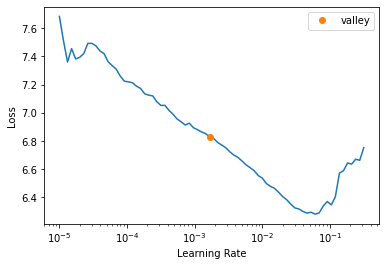

In [26]:
learn_bnb.lr_find(start_lr=1e-05)

In [27]:
learn_bnb.fit_one_cycle(5, 2e-2)

epoch,train_loss,valid_loss,time
0,5.253646,5.065387,00:01
1,4.927999,4.884369,00:01
2,4.782328,4.707303,00:01
3,4.720964,4.725540,00:01
4,4.637159,4.716828,00:01


In [28]:
df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')

,Div,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HC,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
3554,E0,Tottenham,Man City,1.0,0.0,13.0,18.0,3.0,4.0,3.0,...,15,6,227,False,False,False,False,False,False,1.628986e+09


In [29]:
def predict(self, row):
    "Predict on a Pandas Series"
    dl = self.dls.test_dl(row.to_frame().T)
    dl.dataset.conts = dl.dataset.conts.astype(np.float32)
    inp,preds,_ = self.get_preds(dl=dl, with_input=True, with_decoded=False)
    b = tuplify(inp)
    full_dec = self.dls.decode(b)
    return full_dec,preds[0]

learn_bnb.predict = MethodType(predict, learn_bnb)

In [30]:
_, params = learn_bnb.predict(df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')
                                .drop(columns=y_names).iloc[0])

In [31]:
probs = F.softmax(params[0:3], dim=-1)
alpha = F.softplus(params[3])
total_count = 1 / alpha
print(probs, total_count)

bnb_corner = BivariateNegativeBinomial(total_count=total_count, probs=probs)

tensor([0.7714, 0.0966, 0.1320]) tensor(35.0276)


In [32]:
print(bnb_corner.mean, bnb_corner.variance)

tensor([35.0276,  4.3868,  5.9962]) tensor([70.0552,  4.9362,  7.0226])


In [33]:
value = torch.cartesian_prod(torch.arange(0., 15.), torch.arange(0., 15.))

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


In [34]:
corner = bnb_corner.log_prob(value).exp()

In [35]:
line = 10.5
mask = value.sum(-1) < line
prob_lo = corner[mask].sum()
prob_hi = 1 - prob_lo

In [36]:
prob_lo, prob_hi

(tensor(0.5417), tensor(0.4583))

In [37]:
1/prob_lo, 1/prob_hi

(tensor(1.8460), tensor(2.1820))

### Train full model

In [38]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block)

In [39]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg,HC,AC
0,SP1,Leganes,Ath Bilbao,0.6,12.2,4.8,4.4,1.4,12.2,4.6,4.6,0.8,10.4,3.6,2.6,1.4,12.400000,5.4,5.4,2.000000e-01,10.4,2.8,4.800000,1.8,13.400000,6.2,4.0,4.0,3.0
1,D1,Dortmund,M'gladbach,2.6,20.4,7.0,7.2,2.0,12.4,4.2,2.6,2.6,19.4,6.2,5.4,1.4,14.200000,4.0,4.8,7.236054e-09,6.6,2.0,3.200000,1.0,14.000000,4.8,4.4,7.0,0.0
2,I1,Inter,Torino,2.0,14.4,5.4,7.0,1.8,8.8,2.8,4.0,2.0,15.6,7.0,7.0,1.2,8.600001,4.2,3.6,1.600000e+00,11.2,4.0,5.800000,1.2,14.600000,6.0,5.6,5.0,4.0
3,F1,Reims,St Etienne,0.6,13.6,3.6,6.0,1.4,6.8,2.8,3.6,0.4,13.4,4.0,6.0,1.8,10.400000,3.8,3.0,8.000000e-01,9.2,2.4,6.200000,1.0,11.600000,3.8,4.0,1.0,2.0
4,I1,Chievo,Napoli,0.6,10.0,3.0,3.8,3.8,13.0,7.4,4.0,1.0,10.8,3.8,3.0,3.0,17.000000,8.4,6.6,1.400000e+00,18.8,6.8,8.399999,0.8,9.400000,3.6,3.6,6.0,5.0
5,SP1,Espanol,Ath Bilbao,0.6,9.4,4.0,4.8,1.4,12.8,3.8,5.2,1.0,7.0,3.2,3.8,1.2,13.000000,4.6,5.6,1.200000e+00,12.4,3.6,5.400000,0.2,13.000000,3.2,5.2,4.0,2.0
6,SP1,Ath Madrid,Las Palmas,1.2,10.2,4.8,4.6,0.4,7.2,3.2,2.2,1.0,8.8,3.4,3.0,1.0,11.600000,4.0,3.8,3.999999e-01,9.0,3.2,3.200000,2.6,12.800000,6.2,3.8,4.0,1.0
7,I1,Spal,Atalanta,1.2,10.4,3.8,4.2,1.6,16.0,6.8,7.0,1.2,11.8,4.6,5.6,1.6,15.400000,6.8,6.8,8.000000e-01,9.6,4.6,5.000000,1.2,8.399999,4.2,4.8,4.0,4.0
8,SP1,Valladolid,Barcelona,0.6,10.2,2.4,5.8,2.0,13.4,5.8,5.6,0.8,9.6,3.8,3.8,2.0,15.000000,5.0,5.8,8.000000e-01,11.0,2.2,4.800000,1.0,9.600000,3.0,2.6,4.0,5.0
9,E0,Everton,Man City,1.6,10.8,3.2,5.8,1.8,14.4,5.2,7.6,1.6,11.6,4.6,7.2,2.4,15.600000,6.4,7.4,1.000000e+00,13.8,5.0,5.400000,0.4,5.200000,2.0,3.2,2.0,11.0


In [40]:
learn_bnb = tabular_learner(dls, layers=[240, 120], n_out=4)

In [41]:
learn_bnb.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(6, 4)
    (1): Embedding(146, 26)
    (2): Embedding(146, 26)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=80, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=4, bias=True)
    )
  )
)

In [42]:
learn_bnb.loss_func = BivariateNegativeBinomialNLLLoss()
learn_bnb.loss_func

BivariateNegativeBinomialNLLLoss(
  (softmax_probs): Softmax(dim=-1)
  (softplus_total_count): Softplus(beta=1, threshold=20)
)

SuggestedLRs(valley=0.004365158267319202)

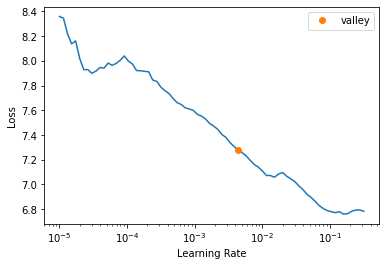

In [43]:
learn_bnb.lr_find(start_lr=1e-05)

In [44]:
learn_bnb.fit_one_cycle(5, 2e-2)

epoch,train_loss,valid_loss,time
0,5.304666,None,00:01
1,4.943069,None,00:01
2,4.814883,None,00:01
3,4.724653,None,00:01
4,4.656386,None,00:01


/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [45]:
learn_bnb.export('models/learn_bnb.pkl')

In [46]:
to.export('models/to.pkl')

### t-SNE

In [83]:
df['HomeTeam'].astype('category').cat.categories.values

array(['Alaves', 'Amiens', 'Angers', 'Arsenal', 'Aston Villa', 'Atalanta',
       'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Barcelona',
       'Bayern Munich', 'Benevento', 'Betis', 'Bielefeld', 'Bochum',
       'Bologna', 'Bordeaux', 'Bournemouth', 'Brentford', 'Brescia',
       'Brest', 'Brighton', 'Burnley', 'Cadiz', 'Caen', 'Cagliari',
       'Cardiff', 'Celta', 'Chelsea', 'Chievo', 'Clermont', 'Crotone',
       'Crystal Palace', 'Dijon', 'Dortmund', 'Eibar', 'Ein Frankfurt',
       'Elche', 'Empoli', 'Espanol', 'Everton', 'FC Koln', 'Fiorentina',
       'Fortuna Dusseldorf', 'Freiburg', 'Frosinone', 'Fulham', 'Genoa',
       'Getafe', 'Girona', 'Granada', 'Greuther Furth', 'Guingamp',
       'Hannover', 'Hertha', 'Hoffenheim', 'Huddersfield', 'Huesca',
       'Inter', 'Juventus', 'Lazio', 'Lecce', 'Leeds', 'Leganes',
       'Leicester', 'Lens', 'Levante', 'Leverkusen', 'Lille', 'Liverpool',
       'Lorient', 'Lyon', "M'gladbach", 'Mainz', 'Mallorca', 'Man City',
       'Man United'

In [84]:
df['AwayTeam'].astype('category').cat.categories.values

array(['Alaves', 'Amiens', 'Angers', 'Arsenal', 'Aston Villa', 'Atalanta',
       'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Barcelona',
       'Bayern Munich', 'Benevento', 'Betis', 'Bielefeld', 'Bochum',
       'Bologna', 'Bordeaux', 'Bournemouth', 'Brentford', 'Brescia',
       'Brest', 'Brighton', 'Burnley', 'Cadiz', 'Caen', 'Cagliari',
       'Cardiff', 'Celta', 'Chelsea', 'Chievo', 'Clermont', 'Crotone',
       'Crystal Palace', 'Dijon', 'Dortmund', 'Eibar', 'Ein Frankfurt',
       'Elche', 'Empoli', 'Espanol', 'Everton', 'FC Koln', 'Fiorentina',
       'Fortuna Dusseldorf', 'Freiburg', 'Frosinone', 'Fulham', 'Genoa',
       'Getafe', 'Girona', 'Granada', 'Greuther Furth', 'Guingamp',
       'Hannover', 'Hertha', 'Hoffenheim', 'Huddersfield', 'Huesca',
       'Inter', 'Juventus', 'Lazio', 'Lecce', 'Leeds', 'Leganes',
       'Leicester', 'Lens', 'Levante', 'Leverkusen', 'Lille', 'Liverpool',
       'Lorient', 'Lyon', "M'gladbach", 'Mainz', 'Mallorca', 'Man City',
       'Man United'

In [85]:
variable = 'HomeTeam'
ix = cat_names.index(variable)

var_vals = list(df[variable].astype('category').cat.categories.values)
nval = len(var_vals)
print(f'Number of values: {nval}')
print(var_vals)

Number of values: 129
['Alaves', 'Amiens', 'Angers', 'Arsenal', 'Aston Villa', 'Atalanta', 'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Barcelona', 'Bayern Munich', 'Benevento', 'Betis', 'Bielefeld', 'Bochum', 'Bologna', 'Bordeaux', 'Bournemouth', 'Brentford', 'Brescia', 'Brest', 'Brighton', 'Burnley', 'Cadiz', 'Caen', 'Cagliari', 'Cardiff', 'Celta', 'Chelsea', 'Chievo', 'Clermont', 'Crotone', 'Crystal Palace', 'Dijon', 'Dortmund', 'Eibar', 'Ein Frankfurt', 'Elche', 'Empoli', 'Espanol', 'Everton', 'FC Koln', 'Fiorentina', 'Fortuna Dusseldorf', 'Freiburg', 'Frosinone', 'Fulham', 'Genoa', 'Getafe', 'Girona', 'Granada', 'Greuther Furth', 'Guingamp', 'Hannover', 'Hertha', 'Hoffenheim', 'Huddersfield', 'Huesca', 'Inter', 'Juventus', 'Lazio', 'Lecce', 'Leeds', 'Leganes', 'Leicester', 'Lens', 'Levante', 'Leverkusen', 'Lille', 'Liverpool', 'Lorient', 'Lyon', "M'gladbach", 'Mainz', 'Mallorca', 'Man City', 'Man United', 'Marseille', 'Metz', 'Milan', 'Monaco', 'Montpellier', 'Nantes', 'Napoli', 'Newc

In [86]:
# import altair as alt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

emb_mx = to_np(next(learn_bnb.model.embeds[ix].parameters()))
#X_emb = TSNE(n_components=2, perplexity=3).fit_transform(emb_mx)
#X_emb = PCA(n_components=2).fit_transform(emb_mx)
annotation = np.append('Other', np.array(var_vals))

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' 

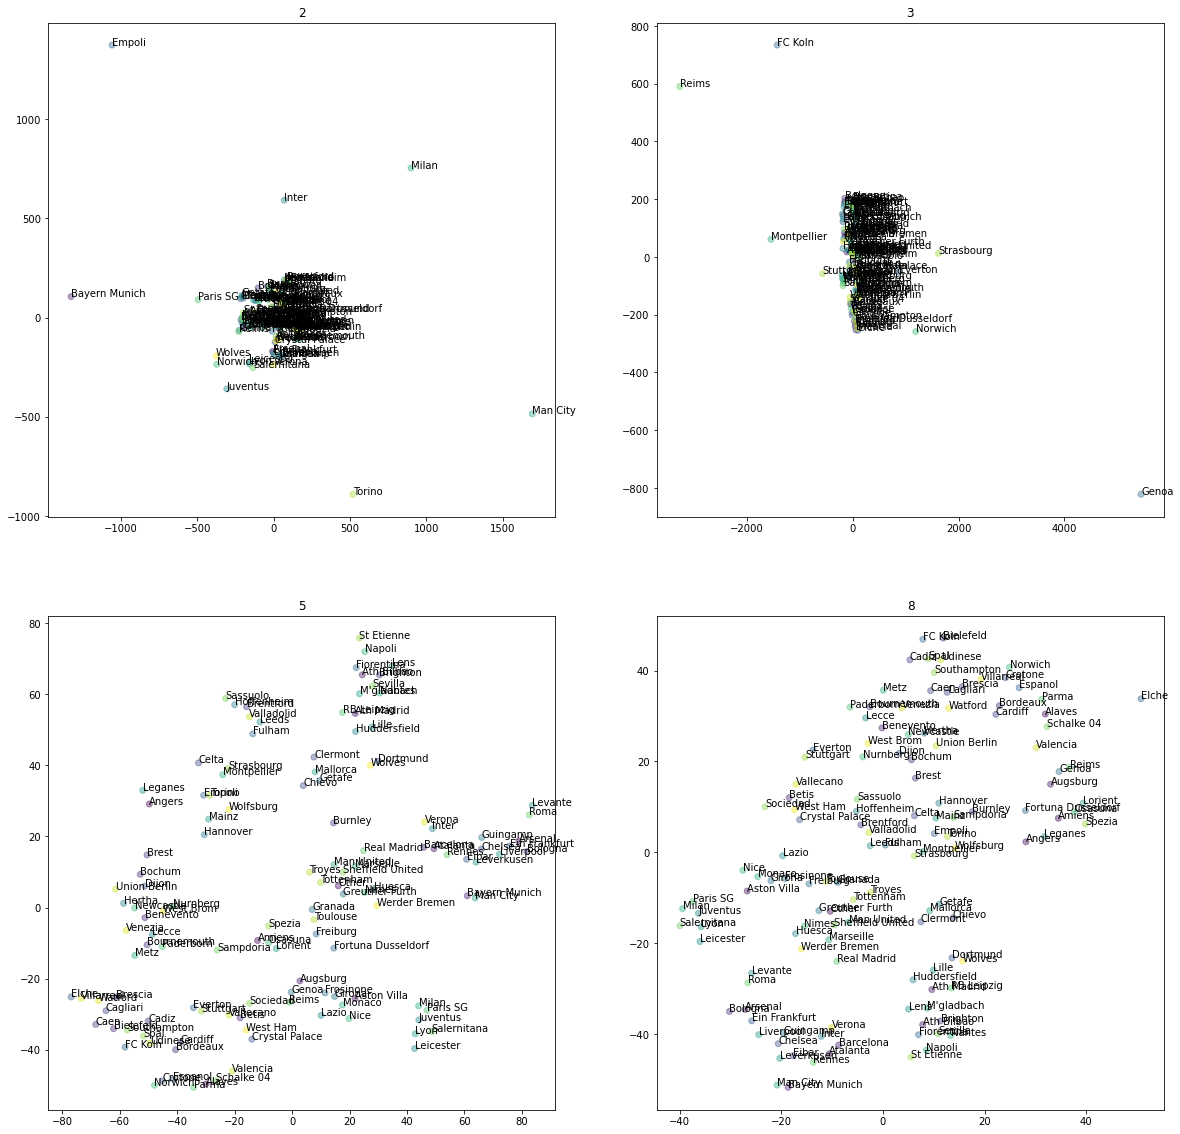

In [87]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(20)
fig.set_figwidth(20)

perplexity = [2, 3, 5, 8]
for ax,perp in zip(axes.flatten(), perplexity):
    X_emb = TSNE(n_components=2, perplexity=perp).fit_transform(emb_mx)
    ax.scatter(X_emb[:,0], X_emb[:,1], c=range(len(annotation)), alpha=0.4)
    for xy,target in zip(X_emb, annotation):
        if isinstance(target, np.str_) or isinstance(target, str):
            text = target
        else:
            text = "%d" % target
        ax.annotate(text=text, xy=(xy[0], xy[1]))
        ax.set_title(perp)

# END